# DRACO - Milestone 2: Dataset exploration

This document is structured as follow:

1. Characters Data - Extraction and Processing
2. Movie Data - Extraction and Processing
3. Actors Ethinicites - Exploration

---

In [75]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
DATA_FOLDER = './Data/'

CHARACTER_PATH = DATA_FOLDER + 'MovieSummaries/character.metadata.tsv'
MOVIE_PATH = DATA_FOLDER + 'MovieSummaries/movie.metadata.tsv'
ETHNICITY_PATH = DATA_FOLDER + 'ethnicities_data.tsv'

## Characters Data - Extraction and Processing

First, we will load the character dataset and the ethnicity dataset. This is done to subsequently merge the two dataframes, connecting the characters with the ethnicity of the actors.

In [77]:
characters = pd.read_csv(CHARACTER_PATH, sep='\t', header=None, 
    names = ["Wikipedia Movie ID", "Freebase Movie ID", "Movie release date", "Character name", "Birth", 
    "Gender", "Height", "Ethnicity ID", "Name", "Age at movie release",
    "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"])
characters.head()

,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character name,Birth,Gender,Height,Ethnicity ID,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [78]:
ethnicities_data = pd.read_csv(ETHNICITY_PATH, sep='\t', 
                               header=None, names=["Ethnicity ID", "Ethnicity"])
ethnicities_data.head()

,Ethnicity ID,Ethnicity
0,Ethnicities ID,Ethnicities
1,/m/044038p,NaN
2,/m/0x67,African Americans
3,/m/064b9n,Omaha people
4,/m/041rx,Jewish people


After loading both datasets, we'll perform an inner join on the column `Ethnicity ID` to retain only the pertinent information.

In [79]:
characters = characters.merge(ethnicities_data.dropna(), how='inner', on='Ethnicity ID')
characters.head()

,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character name,Birth,Gender,Height,Ethnicity ID,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Ethnicity
0,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
1,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,African Americans
2,3196793,/m/08yl5d,2000-02-16,NaN,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp,African Americans
3,156558,/m/014k4y,2001-06-27,Yvette,1970-09-11,F,1.650,/m/0x67,Taraji P. Henson,30.0,/m/0jtx5t,/m/03jnxj_,/m/0blbxk,African Americans
4,156558,/m/014k4y,2001-06-27,Jody,1978-12-30,M,1.797,/m/0x67,Tyrese Gibson,22.0,/m/0jtx5h,/m/03jnxf4,/m/01l1b90,African Americans


## Movie Data - Extraction and Processing

Next, we load the movie dataset. This is essential as we plan to merge the character dataframe with the movie dataframe, creating a comprehensive dataframe that encompasses all character-related information.

In [80]:
movies = pd.read_csv(MOVIE_PATH, sep='\t', header=None, 
    names = ["Wikipedia Movie ID", "Freebase Movie ID", "Movie name","Movie release date", "Box office revenue","Movie runtime","Movie language","Movie countries","Movie genres" ])
movies.head()

,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Box office revenue,Movie runtime,Movie language,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


We can observe that the three columns `Movie language`, `Movie language`, `Movie genres` contain dictionaries. In our case, it would be much more convenient to have lists instead. Let's process it accordingly

In [81]:
movies["Movie countries"] = movies["Movie countries"].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies["Movie language"] = movies["Movie language"].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies["Movie genres"] = movies["Movie genres"].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')

We should also write add a category for the year of release in addition of the date of release

In [82]:
#Errors = 'coerce' will force the values that are outside the bound to be NaT
movies["Movie release year"] = pd.to_datetime(movies["Movie release date"],format='mixed',errors = 'coerce').dt.year
#Remove the NaN and NaT values
movies = movies[movies["Movie release year"].notna()]
#Express all years of realese as int
movies["Movie release year"] = movies["Movie release year"].astype("int")


Now, let's merge the movie dataframe with the character dataframe to create a single dataframe that encompasses all the information about a character along with details about the films they are involved in.

In [83]:
characters_movies = characters.merge(movies, how='inner', on=['Wikipedia Movie ID',"Freebase Movie ID","Movie release date"])
characters_movies.head()

,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character name,Birth,Gender,Height,Ethnicity ID,Name,Age at movie release,...,Freebase character ID,Freebase actor ID,Ethnicity,Movie name,Box office revenue,Movie runtime,Movie language,Movie countries,Movie genres,Movie release year
0,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,/m/0bgchn_,/m/01vw26l,African Americans,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001
1,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,...,/m/0bgchnd,/m/0418ft,African Americans,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001
2,975900,/m/03vyhn,2001-08-24,Tres,1959-03-09,M,NaN,/m/064b9n,Rodney A. Grant,42.0,...,/m/0bgchrw,/m/03ydsb,Omaha people,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001
3,3196793,/m/08yl5d,2000-02-16,NaN,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,...,NaN,/m/01lntp,African Americans,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000
4,156558,/m/014k4y,2001-06-27,Yvette,1970-09-11,F,1.650,/m/0x67,Taraji P. Henson,30.0,...,/m/03jnxj_,/m/0blbxk,African Americans,Baby Boy,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",2001


## Actors Ethinicites - Exploration

Let's visualized the proportion of ethinicties among the characters.

Text(0, 0.5, 'Number of actors')

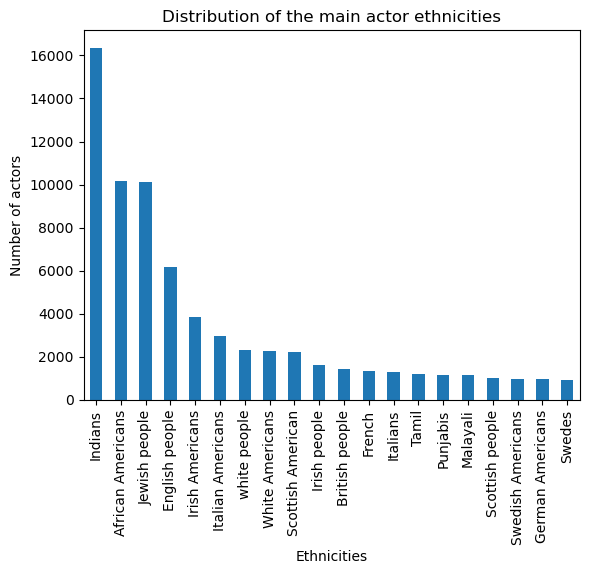

In [84]:
grouped_ethinity = characters.groupby(['Ethnicity']).count()
#grouped_ethinity = grouped_ethinity.div(grouped_ethinity.sum(axis=1), axis=0)
main_ethnicities = grouped_ethinity['Freebase actor ID'].sort_values(ascending=False)[0:20]
main_ethnicities.plot(kind='bar')
plt.title("Distribution of the main actor ethnicities")
plt.xlabel("Ethnicities")
plt.ylabel("Number of actors")

We've noticed that many characters are portrayed by Indian actors. For our project, our primary focus is on Hollywood characters. Let's filter and isolate the Hollywood characters. 

Let's narrow down our selection to include only Hollywood or American characters, meaning those characters that appear in American movies

In [85]:
characters_holywood = characters_movies[characters_movies["Movie countries"].apply(lambda x: 'United States of America' in x)]

Plus we should also remove the actor that have only played in animation, as they're probably voice actors

In [86]:
#characters_holywood = characters_holywood[characters_holywood['Movie genres'].isin('')]

By grouping the data by ethnicities, let's analyse what are the main ethnicties of Hollywoodian actors

In [87]:
H_grouped_ethnicity = characters_holywood.groupby(['Ethnicity']).count()
#Let's take the 10 main actor ethinicities
main_ethinicities = H_grouped_ethnicity['Freebase actor ID'].sort_values(ascending=False)[0:10].index
main_characters_holywood = characters_holywood[characters_holywood['Ethnicity'].isin(main_ethinicities)]
main_ethinicities

Index(['African Americans', 'Jewish people', 'Irish Americans',
       'English people', 'Italian Americans', 'White Americans',
       'Scottish American', 'white people', 'Irish people',
       'Swedish Americans'],
      dtype='object', name='Ethnicity')

Now let's visualize the distribution of holywoodian actors

Text(0, 0.5, 'Number of actors')

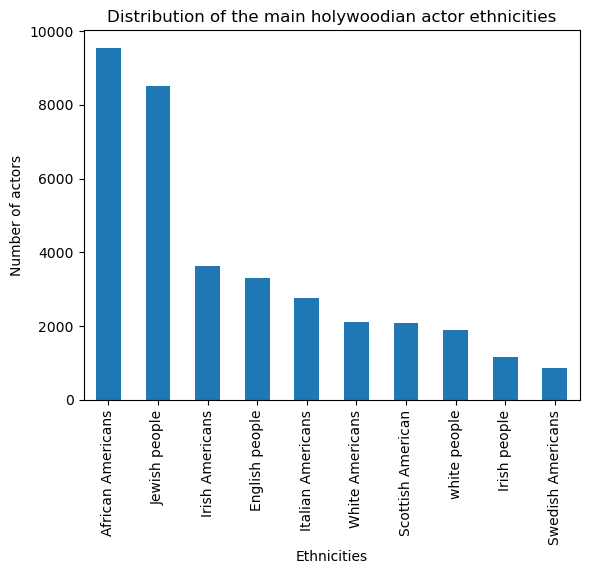

In [88]:
main_holywoodian_ethnicities =  H_grouped_ethnicity.loc[main_ethinicities]['Freebase actor ID']
main_holywoodian_ethnicities.plot(kind='bar')
plt.title("Distribution of the main holywoodian actor ethnicities")
plt.xlabel("Ethnicities")
plt.ylabel("Number of actors")

In [98]:
np.arange(main_characters_holywood['Movie release year'].min(),main_characters_holywood['Movie release year'].max(),100)

array([1903, 2003])

array([1903, 1913, 1923, 1933, 1943, 1953, 1963, 1973, 1983, 1993, 2003,
       2013])

Text(0, 0.5, 'Proportion')

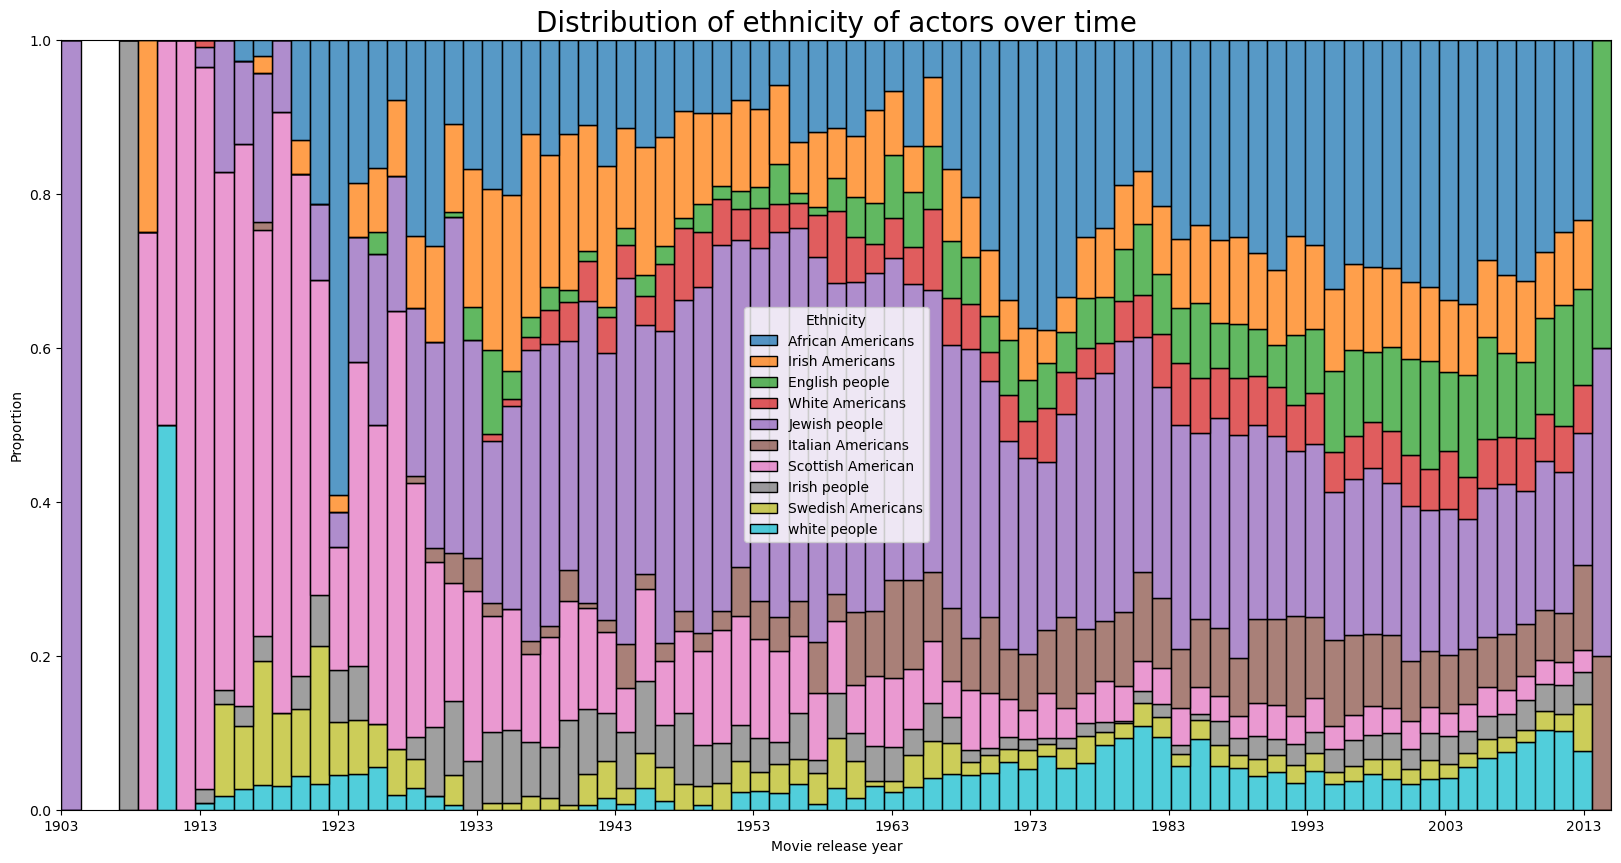

In [111]:
plt.figure(figsize=(20,10))
sns.histplot(data=main_characters_holywood,x='Movie release year',hue='Ethnicity',multiple='fill',stat='probability')
plt.title("Distribution of ethnicity of actors over time",fontsize=20)
plt.xticks(np.arange(main_characters_holywood['Movie release year'].min(),main_characters_holywood['Movie release year'].max(),10))
plt.ylabel('Proportion')


In [ ]:
H_ethinity_M = characters_holywood[characters_holywood['Gender'] == 'M'].groupby(['Ethnicity']).count()
main_H_ethnicities_M = H_ethinity_M['Freebase actor ID'].sort_values(ascending=False)[0:20]

H_ethinity_F = characters_holywood[characters_holywood['Gender'] == 'F'].groupby(['Ethnicity']).count()
main_H_ethnicities_F = H_ethinity_F.loc[main_H_ethnicities_M.index]['Freebase actor ID'].sort_values(ascending=False)
main_H_ethnicities_F_reversed = main_H_ethnicities_F*(-1)

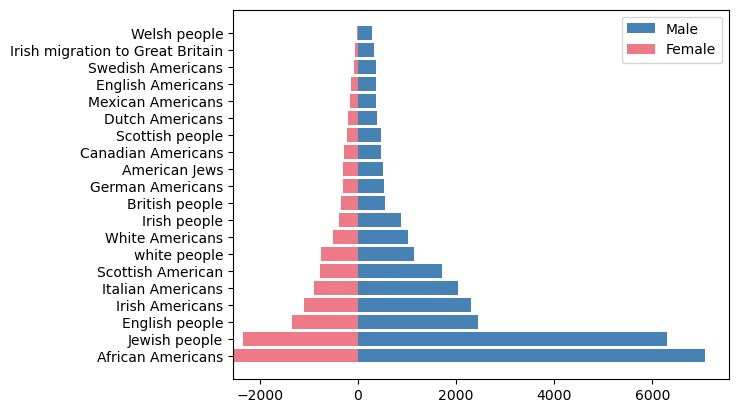

In [ ]:
plt.barh(y=main_H_ethnicities_M.index, width=main_H_ethnicities_M.values, color="#4682b4", label="Male")
plt.barh(y=main_H_ethnicities_M.index, width=main_H_ethnicities_F.values, left=main_H_ethnicities_F_reversed.values,
         color="#ee7a87", label="Female")
plt.legend()